In [1]:
import csv
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from math import sqrt
import analyze
from itertools import chain

/Users/steve/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
f = open('data/time_series_covid19_deaths_global.csv')
reader = csv.reader(f)
first = True
rows = []

num_cols = 62
def default():
  return np.zeros(shape=(num_cols,))
province_counts = defaultdict(default)
agg_counts = defaultdict(default)
region_counts = defaultdict(default)
us_counts = defaultdict(default)
for row in reader:
  if first:
    columns = row
    first = False
  else:
    rows.append(row)
    series = np.array(list(map(float, row[4:])))
    if row[0] == '':
      region_counts['{} (Deaths)'.format(row[1])] = series
    else:
      province_counts[row[0]] = series
      agg_counts[row[1]] += series
# for US data
f = open('data/time_series_19-covid-Deaths.csv')
reader = csv.reader(f)
first = True
for row in reader:
  if first:
    first = False
  else:
    if row[1] == 'US' and row[0] != 'US' and row[0][-4] != ',':
      if row[-1] == '':
        row[-1] = -1
      series = np.array(list(map(float, row[4:])))
      us_counts[row[0]] = series
f = open('data/us_mar23.csv')
reader = csv.reader(f)
for row in reader:
  count = row[3]
  if count == '':
    count = -1
  us_counts[row[0]][-1] = int(count)

In [77]:
hosps = {
    'SCC (Hosps from 3/12)' : {
        'day' : np.array([12, 13, 14, 15, 17, 18, 19, 20, 21, 22]),
        'count' : np.array([37, 38, 48, 52, 56, 62, 65, 93, 108, 116])
    },
    'SCC (Deaths from 3/12)' : {
        'day' : None,#np.array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]),
        'count' : np.array([1, 2, 2, 4, 5, 6, 6, 8, 8, 10, 13, 16, 17, 19, 20])
    },
    'NYS (Hosps from 3/17)' : {
        'day' : np.array([17, 18, 19, 20, 21, 22, 23, 24, 25]), 
        'count' : np.array([264, 549, 777, 1255, 1603, 1974, 2635, 3234, 3805])
    },
    'NYS (Hosps from 3/12)' : {
        'day' : np.array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]),
        'count' : np.array([47, 50, 117, 137, 158, 264, 549, 777, 1255, 1603, 1974, 2635, 3234, 3805])
    },
    'NYS (Deaths from 3/17)' : {
        'day' : np.array([17, 18, 19, 20, 21, 22, 23]), 
        'count' : np.array([13.,  16.,  34.,  42.,  60., 117., 157.]) 
    },
    'somewhere' : {
        'day' : None,
        'count' : np.array([0,
1,
1,
2,
2,
3,
3,
3,
4,
5,
6,
10,
11,
14,
16,
19,
20,
21,
23,
25,
25,
26,
27,
27,
29,
29])
    }    
}

In [78]:
def calculate_growth(series, days=None, thresh=10, start=5):
  if days is None:
      days = np.arange(0, series.shape[0])
  if ((series < thresh).all()):
    return None
  keep = series >= start
  series = series[keep]
  days = days[keep]
  if (days.shape[0] < 5):
    return None
  print(series)
  print(days)
  model = analyze.ExponentialGrowthRateEstimator(family='NegativeBinomial', alpha=0.05)
  model.fit(day=days, cases=series)
  print(np.diff(series))
  print(model.fitted_glm.mu)
  est = model.growth_rate()
  low, high = model.growth_rate_confint()
  return (max(low, 0), est, high)

In [79]:
growths = dict()
dataset = region_counts.items()
for k, v in dataset:
  growth = calculate_growth(v, thresh = 50, start = 5)
  if growth:
    print(' (for %s)' % k)
    growths[k] = growth

for k, v in hosps.items():
  growth = calculate_growth(v['count'], v['day'], thresh = 10, start = 5)
  if growth:
    print(' (for %s)' % k)
    growths[k] = growth

[ 5. 10. 14. 21. 37. 67. 75. 88.]
[54 55 56 57 58 59 60 61]
[0. 0. 0. 0. 0. 0. 0.]
[ 5.  4.  7. 16. 30.  8. 13.]
[ 6.24543671  7.56846954  9.17177355 11.11472135 13.46926307 16.32259072
 19.78036709]
 (for Belgium (Deaths))
[  6.   9.  11.  19.  19.  33.  48.  48.  79.  91.  91. 148. 148. 148.
 243. 450. 562. 674. 860.]
[43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[  3.   2.   8.   0.  14.  15.   0.  31.  12.   0.  57.   0.   0.  95.
 207. 112. 112. 186.]
[  2.41481807   3.1243068    4.04224779   5.2298856    6.76645887
   8.75448703  11.32661036  14.6544397   18.96000623  24.53057527
  31.73781251  41.06258138  53.12702596  68.73608021  88.93117275
 115.05971045 148.8649768  192.60244295]
 (for France (Deaths))
[  7.   9.  11.  17.  24.  28.  44.  67.  84.  94. 123.]
[51 52 53 54 55 56 57 58 59 60 61]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 2.  2.  6.  7.  4. 16. 23. 17. 10. 29.]
[ 3.01095352  3.85975967  4.94784946  6.34

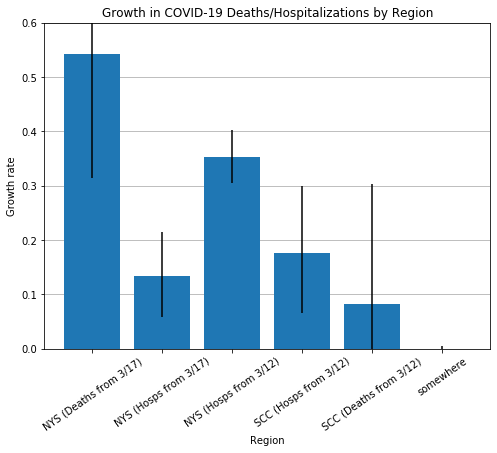

In [80]:
to_plot = {k:growths[k] for k in ['US (Deaths)', 'Spain (Deaths)', 'Italy (Deaths)', 'NYS (Deaths from 3/17)', 'NYS (Hosps from 3/17)', 'SCC (Hosps from 3/12)']}
to_plot = {k:growths[k] for k in ['NYS (Deaths from 3/17)', 'NYS (Hosps from 3/17)', 'NYS (Hosps from 3/12)', 'SCC (Hosps from 3/12)', 'SCC (Deaths from 3/12)', 'somewhere']}
names = list(to_plot.keys())
err_l = list([v[1]-v[0] for v in to_plot.values()])
ests  = list([v[1] for v in to_plot.values()])
err_h = list([v[2]-v[1] for v in to_plot.values()])
errs = np.array([err_l, err_h])
plt.rcParams['axes.axisbelow'] = True
plt.bar(range(len(names)), ests, yerr=errs, align='center')
plt.ylim([0,0.6])
plt.grid(axis='y')
plt.xlabel('Region')
plt.xticks(rotation=35)
plt.ylabel('Growth rate')
plt.title('Growth in COVID-19 Deaths/Hospitalizations by Region')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)


plt.xticks(range(len(names)), names)
plt.show()

In [81]:
print(to_plot)

{'NYS (Deaths from 3/17)': (0.3138511520623406, 0.5425602635026516, 0.8110819957057558), 'NYS (Hosps from 3/17)': (0.05759511147189311, 0.13349247721059165, 0.21483654940962627), 'NYS (Hosps from 3/12)': (0.3039506238215388, 0.35185937768102304, 0.40152835823501376), 'SCC (Hosps from 3/12)': (0.06496387188464614, 0.17636221705536848, 0.29941315592846185), 'SCC (Deaths from 3/12)': (0, 0.0823829839620609, 0.3030668194333961), 'somewhere': (0, -0.08610944979750734, 0.004661233053008473)}


In [33]:
cum_preds = 264 + np.cumsum(np.array([0, 274.32275035, 310.96712133, 352.50649254, 399.59474414, 452.9731024,
 513.48180753, 582.07334004, 659.82741398, 1.134*659.82741398]))

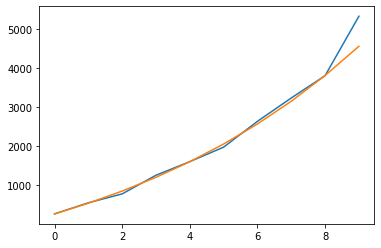

In [34]:
plt.plot([264, 549, 777, 1255, 1603, 1974, 2635, 3234, 3805, 5327])
plt.plot(cum_preds)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (15,) and (16,)

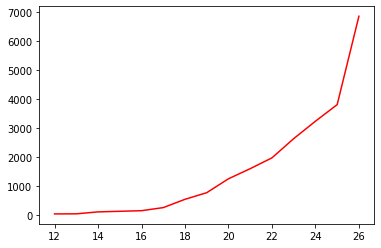

In [52]:
day = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 72]
guess = 47 + np.cumsum(np.array([0, 28.91470084,   39.35819335,   53.57369569 ,  72.92359291 ,  99.26234012,
  135.1141897,   183.91511056,  250.34208449,  340.76133862,  463.8384718,
  631.36894812,  859.40855035, 1169.8121338, 1169.8121338*1.3611, 1169.8121338*(1.3611**2)]))
actual = np.array([47, 50, 117, 137, 158, 264, 549, 777, 1255, 1603, 1974, 2635, 3234, 3805, 6844,])
plt.plot(day, actual, color='r')
plt.plot(day, guess)
plt.show()

[ 37.          40.56038264  44.74868226  49.67563968  57.1005647
  65.12107518  74.55610067  85.65510818  98.71156126 114.07067935
 132.13856556 152.43146087 176.30325619 204.38513425 237.4195946 ]


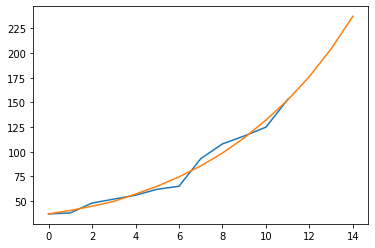

In [51]:

guess = 37 + np.cumsum(np.array([0, 3.56038264,  4.18829962,  4.92695742,  7.42492502,  8.02051048,  9.43502549,
 11.09900751, 13.05645308, 15.35911809,  15.35911809*(1+to_plot['SCC (Hosps from 3/12)'][1]), 14.66431836*(1+to_plot['SCC (Hosps from 3/12)'][1]) ** 2, 14.66431836*(1+to_plot['SCC (Hosps from 3/12)'][1]) ** 3, 14.66431836*(1+to_plot['SCC (Hosps from 3/12)'][1]) ** 4, 14.66431836*(1+to_plot['SCC (Hosps from 3/12)'][1]) ** 5]))
actual = np.array([37, 38,  48,  52,  56,  62,  65,  93, 108, 116, 125, 153])
print(guess)
plt.plot(actual)
plt.plot(guess)
plt.show()